In [50]:
import tonic
import tonic.transforms as tonic_transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
data_path = "./data/nmnist"

In [36]:
# (Down)load the dataset and print some information

dataset = tonic.datasets.NMNIST(
    save_to='./data/nmnist',
    train=True
)

print(f"Number of samples: {len(dataset)}"
      f"\nNumber of classes: {dataset.classes}"
      f"\nSample shape: {dataset[0]}")

Number of samples: 60000
Number of classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Sample shape: (array([(10, 30,    937, 1), (33, 20,   1030, 1), (12, 27,   1052, 1), ...,
       ( 7, 15, 302706, 1), (26, 11, 303852, 1), (11, 17, 305341, 1)],
      dtype=[('x', '<i4'), ('y', '<i4'), ('t', '<i4'), ('p', '<i4')]), 0)


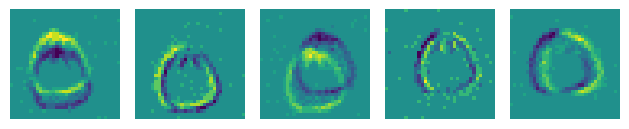

In [37]:
# Print some sample 

sensor_size = tonic.datasets.NMNIST.sensor_size
time_bins = 5
idx = 1000

events, target = dataset[idx]

frame_transform = tonic_transforms.ToFrame(
    sensor_size=sensor_size,
    n_time_bins=time_bins
)

frames = frame_transform(events)

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames))
    for axis, frame in zip(axes, frames):
        axis.imshow(frame[1] - frame[0])
        axis.axis("off")
    plt.tight_layout()


plot_frames(frames)

In [38]:
# lets make a transform to make sure only positive events are used
class OnlyPositve(object):
    def __call__(self, frames):
        return frames[:, 1:2, :, :]

In [39]:
# transform compose, train and test datasets + loaders, settings
sensor_size = tonic.datasets.NMNIST.sensor_size
time_bin_width_us = 1000
batch_size = 16

frame_transform = tonic_transforms.Compose([
    tonic_transforms.ToFrame(sensor_size=sensor_size, time_window=time_bin_width_us),
    OnlyPositve()
])

trainset = tonic.datasets.NMNIST(save_to=data_path, transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to=data_path, transform=frame_transform, train=False)

trainloader = DataLoader(trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [41]:
# sanity check
frames, targets = next(iter(trainloader))
print("frames shape:", frames.shape)  # [batch, time, polarity, H, W]
print("targets shape:", targets.shape)

frames shape: torch.Size([16, 312, 1, 34, 34])
targets shape: torch.Size([16])


In [ ]:
class SumPooling2D(nn.Module):
    def __init__(
            self,
            kernel_size: int,
            stride: int
    ):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # get input dimensions
        batch_size, num_channels, height, width = x.shape
        x_unfold = F.unfold(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride
        )
        #[batch, channels, window_area, num_windows]

        window_area = self.kernel_size ** 2
        num_windows = x_unfold.shape[-1]
        x_unfold = x_unfold.view(
            batch_size,
            num_channels,
            window_area,
            num_windows
        )

        pooled_sums = x_unfold.sum(dim=2)

        height_out = (height - self.kernel_size) // self.stride + 1
        width_out = (width - self.kernel_size) // self.stride + 1

        pooled_sums_2d = pooled_sums.view(
            batch_size,
            num_channels,
            height_out,
            width_out
        )

        return pooled_sums_2d

In [46]:
# test the pooling layer
x = torch.arange(2*3*6*6).view(2, 3, 6, 6).float()
sum_pool = SumPooling2D(kernel_size=2, stride=2)
output = sum_pool(x)

print("input shape:", x.shape)
print("output shape:", output.shape)
print("input:", x)
print("output:", output)

input shape: torch.Size([2, 3, 6, 6])
output shape: torch.Size([2, 3, 3, 3])
input: tensor([[[[  0.,   1.,   2.,   3.,   4.,   5.],
          [  6.,   7.,   8.,   9.,  10.,  11.],
          [ 12.,  13.,  14.,  15.,  16.,  17.],
          [ 18.,  19.,  20.,  21.,  22.,  23.],
          [ 24.,  25.,  26.,  27.,  28.,  29.],
          [ 30.,  31.,  32.,  33.,  34.,  35.]],

         [[ 36.,  37.,  38.,  39.,  40.,  41.],
          [ 42.,  43.,  44.,  45.,  46.,  47.],
          [ 48.,  49.,  50.,  51.,  52.,  53.],
          [ 54.,  55.,  56.,  57.,  58.,  59.],
          [ 60.,  61.,  62.,  63.,  64.,  65.],
          [ 66.,  67.,  68.,  69.,  70.,  71.]],

         [[ 72.,  73.,  74.,  75.,  76.,  77.],
          [ 78.,  79.,  80.,  81.,  82.,  83.],
          [ 84.,  85.,  86.,  87.,  88.,  89.],
          [ 90.,  91.,  92.,  93.,  94.,  95.],
          [ 96.,  97.,  98.,  99., 100., 101.],
          [102., 103., 104., 105., 106., 107.]]],


        [[[108., 109., 110., 111., 112., 113

In [49]:
class Net(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            num_classes: int,
            kernel_size_conv: int,
            kernel_size_pool: int,
            stride_pool: int,
            pool_threshold: float,
            neuron_threshold: float,
            neuron_reset_value: float,
            decay: float
    ): 
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_classes,
            kernel_size=kernel_size_conv,
            stride=1,
            padding=0
        )
        self.sum_pool = SumPooling2D(
            kernel_size=kernel_size_pool,
            stride=stride_pool
        )
        self.neuron_threshold = neuron_threshold
        self.pool_threshold = pool_threshold
        self.decay = decay
        self.neuron_reset_value = neuron_reset_value
    
    def forward(self, input_sequence):
        batch_size, num_steps, _, height, width = input_sequence.shape
        device = input_sequence.device

        conv_out = self.conv(input_sequence[:,0])
        _, num_classes, conv_h, conv_w = conv_out.shape

        membrane = torch.zeros(batch_size, num_classes, conv_h, conv_w, device=device)
        spike_trains = []

        for t in range(num_steps):
            #convolution
            conv_out = self.conv(input_sequence[:,t])

            #membrane update
            membrane = membrane - self.decay + conv_out

            #pooling for output spikes
            pooled_sums = self.sum_pool(membrane)
            spikes = (pooled_sums >= self.pool_threshold)
            spike_trains.append(spikes)

            #membrane thresholding
            reset_mask = membrane >= self.neuron_threshold
            membrane = membrane.masked_fill(reset_mask, self.neuron_reset_value)

        spike_trains = torch.stack(spike_trains, dim=0)
        spike_trains = spike_trains.permute(1, 0, 2, 3, 4)
        # [batch, time, num_classes, height, width]
        class_scores = spike_trains.sum(dim=(1,3,4)).float()
        return class_scores

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [53]:
model = Net(
    in_channels=1,
    out_channels=10,              # or just num_classes=10 if out_channels unused
    num_classes=10,
    kernel_size_conv=3,
    kernel_size_pool=2,
    stride_pool=2,
    pool_threshold=3.0,
    neuron_threshold=1.0,
    neuron_reset_value=0.0,
    decay=0.95
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model.train()
total_loss = 0
total_correct = 0
total_samples = 0

for frames, targets in train_loader:
    frames, targets = frames.to(device), targets.to(device)
    optimizer.zero_grad()

    # Forward pass
    class_scores = model(frames)  # [batch, num_classes]

    # Loss
    loss = criterion(class_scores, targets)
    loss.backward()
    optimizer.step()

    total_loss += loss.item() * frames.size(0)
    # Compute predictions
    preds = class_scores.argmax(dim=1)
    total_correct += (preds == targets).sum().item()
    total_samples += frames.size(0)

print(f"Epoch 1 finished: Loss = {total_loss / total_samples:.4f}, "
      f"Accuracy = {total_correct / total_samples:.4f}")
